### Structures
Definition of basic structures for computational graph

In [1]:
abstract type GraphNode end
abstract type Operator <: GraphNode end

struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

### Pretty-printing
It helps tracking what happens

In [2]:
import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 276 methods)

### Graph building
At first we have a set of loosely-coupled graph nodes. The following procedures build a proper graph!

In [3]:
function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

topological_sort (generic function with 1 method)

### Forward pass

In [4]:
reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        reset!(node)
    end
    return last(order).output
end

forward! (generic function with 1 method)

### Backward pass

In [5]:
update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed=1.0)
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end

backward! (generic function with 4 methods)

### Implemented operations
Below is the list of supported operations on graph nodes

#### Scalar operators

In [6]:
import Base: ^
^(x::GraphNode, n::GraphNode) = ScalarOperator(^, x, n)
forward(::ScalarOperator{typeof(^)}, x, n) = return x^n
backward(::ScalarOperator{typeof(^)}, x, n, g) = tuple(g * n * x ^ (n-1), g * log(abs(x)) * x ^ n)

backward (generic function with 1 method)

In [7]:
import Base: sin
sin(x::GraphNode) = ScalarOperator(sin, x)
forward(::ScalarOperator{typeof(sin)}, x) = return sin(x)
backward(::ScalarOperator{typeof(sin)}, x, g) = tuple(g * cos(x))

backward (generic function with 2 methods)

#### Broadcasted operators
The operations act on vectors of values so, the gradients are computed as vector-jacobian-products.

In [8]:
import Base: *
import LinearAlgebra: mul!
# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A, x) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A, x, g) = tuple(g * x', A' * g)

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x, y) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x, y, g) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(y .* 𝟏)
    Jy = diagm(x .* 𝟏)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 4 methods)

In [9]:
Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x, y) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x, y, g) = tuple(g,-g)

backward (generic function with 5 methods)

In [10]:
Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x, y) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x, y, g) = tuple(g, g)

backward (generic function with 6 methods)

In [11]:
import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x, g) = let
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

backward (generic function with 7 methods)

In [12]:
Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x, y) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x, y::Real, g) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(𝟏 ./ y)
    Jy = (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 8 methods)

In [13]:
import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x, y) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x, y, g) = let
    Jx = diagm(isless.(y, x))
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 9 methods)

In [14]:
include("other_rules.jl")

backward (generic function with 13 methods)

## Testing area!
Below we will perform few tests.

In [15]:
x = Variable(5.0, name="x")
two = Constant(2.0)
squared = x^two
sine = sin(squared)

order = topological_sort(sine)

4-element Vector{Any}:
 var x
 ┣━ ^ Float64
 ┗━ ∇ Nothing
 const 2.0
 op ?(typeof(^))
 op ?(typeof(sin))

In [16]:
y = forward!(order)

-0.13235175009777303

In [17]:
backward!(order)

In [18]:
x.gradient

9.912028118634735

### The simplest multilayer-perceptron

In [19]:
using LinearAlgebra
Wh  = Variable(randn(10,2), name="wh")
Wo  = Variable(randn(1,10), name="wo")
x = Variable([1.98, 4.434], name="x")
y = Variable([0.064], name="y")
losses = Float64[]

function dense(w, b, x, activation) return activation(w * x .+ b) end
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return Constant(0.5) .* (y .- ŷ) .^ Constant(2)
end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(wo, x̂)
    ŷ.name = "ŷ"
    E = mean_squared_loss(y, ŷ)
    E.name = "loss"

    return topological_sort(E)
end
graph = net(x, Wh, Wo, y)
forward!(graph)
backward!(graph)

for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. const 0.5
2. var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1×1 Matrix{Float64}
3. var wo
 ┣━ ^ 1×10 Matrix{Float64}
 ┗━ ∇ 1×10 Matrix{Float64}
4. var wh
 ┣━ ^ 10×2 Matrix{Float64}
 ┗━ ∇ 10×2 Matrix{Float64}
5. var x
 ┣━ ^ 2-element Vector{Float64}
 ┗━ ∇ 2×1 Matrix{Float64}
6. op.?(typeof(mul!))
7. op.x̂(typeof(σ))
8. op.ŷ(typeof(mul!))
9. op.?(typeof(-))
10. const 2
11. op.?(typeof(^))
12. op.loss(typeof(*))


### Manual derivatives for comparison

In [20]:
eye(n) = diagm(ones(n))
Eŷ  = graph[8].output - y.output #ŷ
ŷȳ  = graph[8].output |> length |> eye #ŷ
ȳWo = graph[7].output |> transpose #x̂
x̄Wh = graph[5].output |> transpose #x
ȳx̂  = graph[3].output |> transpose #Wo
x̂x̄  = graph[7].output .* (1.0 .- graph[7].output) |> diagm #x̂
Eȳ  = ŷȳ * Eŷ
Ex̂  = ȳx̂ * Eȳ
Ex̄  = x̂x̄ * Ex̂
EWo = Eȳ * ȳWo
EWh = Ex̄ * x̄Wh
nothing

In [21]:
EWh

10×2 Matrix{Float64}:
 -0.244705     -0.547991
 -0.109261     -0.244678
  0.752066      1.68417
  0.000550744   0.00123333
  1.24728       2.79315
  0.00389548    0.00872351
  2.93967       6.58308
  0.100424      0.224889
  0.437819      0.980449
 -0.151132     -0.338444

In [22]:
currentloss = forward!(graph)
backward!(graph)
Wh.output -= 0.01Wh.gradient
Wo.output -= 0.01Wo.gradient
println("Current loss: ", currentloss)
push!(losses, first(currentloss))


Current loss: [15.888067955906543]


1-element Vector{Float64}:
 15.888067955906543

In [23]:
x.gradient

2×1 Matrix{Float64}:
 0.1916863939736537
 1.182506448047368

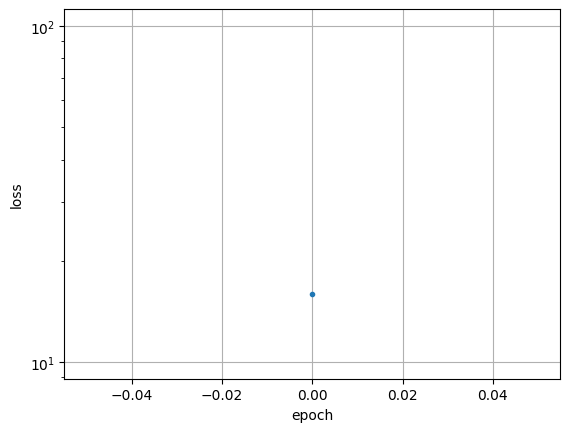

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:198
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/bach/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [24]:
using PyPlot
semilogy(losses, ".")
xlabel("epoch")
ylabel("loss")
grid()

In [25]:
softmax(x::GraphNode) = BroadcastedOperator(softmax, x)
forward(::BroadcastedOperator{typeof(softmax)}, x) = return exp.(x) ./ sum(exp.(x))
backward(node::BroadcastedOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 14 methods)

In [26]:
rosenbrock(x, y) = (Constant(1.0) .- x .* x) .+ Constant(100.0) .* (y .- x .* x) .* (y .- x .* x)

rosenbrock (generic function with 1 method)

In [30]:
import Random: shuffle, shuffle!, seed!
seed!(0)

cross_entropy_loss(y, ŷ) = sum(Constant(-1.0) .* y .* log.(ŷ))
linear(x) = x
ReLU(x) = max.(Constant(0.0), x)
swish(x) = x ./ (Constant(1.0) .+ exp.(Constant(-1) * x))
input_neurons  = 4
hidden_neurons = 8
output_neurons = 3

wh = Variable(randn(hidden_neurons, input_neurons), name="wh")
wo = Variable(randn(output_neurons, hidden_neurons), name="wo")
bh = Variable(zeros(hidden_neurons), name="bh")
bo = Variable(zeros(output_neurons), name="bo")
x = Variable(zeros(input_neurons), name="x")
y = Variable(zeros(output_neurons), name="y")
η = 0.001
epochs = 900

function net(x, wh, bh, wo, bo)
    x̂ = dense(wh, bh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(wo, bo, x̂, z -> let y = exp.(z); y ./ sum(y) end)
    ŷ.name = "ŷ"
    return ŷ
end

function loss(x, y, wh, bh, wo, bo)
    ŷ = net(x, wh, bh, wo, bo)
    E = cross_entropy_loss(y, ŷ); E.name = "loss"
    return E
end

include("iris.jl")
test_size  = 10
train_size = 140
data_size  = train_size + test_size
train_set  = shuffle(1:data_size)[1:train_size]
test_set   = setdiff(1:data_size, train_set)
graph = topological_sort(loss(x, y, wh, bh, wo, bo))
for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. const -1.0
2. var y
 ┣━ ^ 3-element Vector{Float64}
 ┗━ ∇ Nothing
3. op.?(typeof(*))
4. var wo
 ┣━ ^ 3×8 Matrix{Float64}
 ┗━ ∇ Nothing
5. var wh
 ┣━ ^ 8×4 Matrix{Float64}
 ┗━ ∇ Nothing
6. var x
 ┣━ ^ 4-element Vector{Float64}
 ┗━ ∇ Nothing
7. op.?(typeof(mul!))
8. var bh
 ┣━ ^ 8-element Vector{Float64}
 ┗━ ∇ Nothing
9. op.?(typeof(+))
10. op.x̂(typeof(σ))
11. op.?(typeof(mul!))
12. var bo
 ┣━ ^ 3-element Vector{Float64}
 ┗━ ∇ Nothing
13. op.?(typeof(+))
14. op.?(typeof(exp))
15. op.?(typeof(sum))
16. op.ŷ(typeof(/))
17. op.?(typeof(log))
18. op.?(typeof(*))
19. op.loss(typeof(sum))


In [31]:
function test(set)
  L = 0.0
  for j = set
    x.output .= inputs[j,:]
    y.output .= targets[j,:]
    L += forward!(graph)
  end
  return L / length(set) 
end

function train(batch)
  ∇wh = zeros(hidden_neurons, input_neurons)
  ∇wo = zeros(output_neurons, hidden_neurons)
  ∇bh = zeros(hidden_neurons)
  ∇bo = zeros(output_neurons)
  for j = batch
    x.output .= inputs[j,:]
    y.output .= targets[j,:]
    forward!(graph)
    backward!(graph)
    ∇wh .+= wh.gradient
    ∇wo .+= wo.gradient
    ∇bh .+= bh.gradient
    ∇bo .+= bo.gradient
  end
  wh.output .-= η / length(batch) * ∇wh
  bh.output .-= η / length(batch) * ∇bh
  wo.output .-= η / length(batch) * ∇wo
  bo.output .-= η / length(batch) * ∇bo
  forward!(graph)
  return nothing
end

for i=1:epochs
  shuffle!(train_set)
  train(train_set[1:10])
  @show test(test_set)
end

test(test_set) = 2.168292144192796
test(test_set) = 2.163350532440505
test(test_set) = 2.1598709432765704
test(test_set) = 2.15597978655256
test(test_set) = 2.152700542420117
test(test_set) = 2.14861164342377
test(test_set) = 2.1444387295569842
test(test_set) = 2.13946448085573
test(test_set) = 2.1361094787441326
test(test_set) = 2.133416112683451
test(test_set) = 2.130804478506205
test(test_set) = 2.128451044960854
test(test_set) = 2.124134561835662
test(test_set) = 2.120616296236201
test(test_set) = 2.1162143027581237
test(test_set) = 2.112526881151459
test(test_set) = 2.111262448754048
test(test_set) = 2.1077608027904184
test(test_set) = 2.1028810669297457
test(test_set) = 2.0992015590716884
test(test_set) = 2.0951612652223846
test(test_set) = 2.091690253726602
test(test_set) = 2.087670208470106
test(test_set) = 2.083349919749689
test(test_set) = 2.078935302079747
test(test_set) = 2.07545009096808
test(test_set) = 2.073041333273345
test(test_set) = 2.069035712599392
test(test_set) =

test(test_set) = 1.4958730485937883
test(test_set) = 1.4948517936081964
test(test_set) = 1.4939583058913282
test(test_set) = 1.4929899332331331
test(test_set) = 1.4919565675895696
test(test_set) = 1.4910563739026128
test(test_set) = 1.490372519468679
test(test_set) = 1.4893414259199662
test(test_set) = 1.4882871855793969
test(test_set) = 1.4875031579839946
test(test_set) = 1.4864628441253527
test(test_set) = 1.4859348064730025
test(test_set) = 1.4850111887831305
test(test_set) = 1.4841158757517485
test(test_set) = 1.4833769612984495
test(test_set) = 1.4826222815509555
test(test_set) = 1.4818080678214702
test(test_set) = 1.4811579790897471
test(test_set) = 1.4806736644554532
test(test_set) = 1.48007135921398
test(test_set) = 1.4792833929947813
test(test_set) = 1.478193385880914
test(test_set) = 1.477388102310692
test(test_set) = 1.4764570385438827
test(test_set) = 1.4757249873198952
test(test_set) = 1.4747394572519852
test(test_set) = 1.473939383660051
test(test_set) = 1.473048267427100

test(test_set) = 1.3370948132255152
test(test_set) = 1.3367610354310866
test(test_set) = 1.3364290144091242
test(test_set) = 1.3359348722511892
test(test_set) = 1.3352142448300404
test(test_set) = 1.3349673064802534
test(test_set) = 1.3343061375589185
test(test_set) = 1.33420559343431
test(test_set) = 1.3337578687941758
test(test_set) = 1.3333260607328918
test(test_set) = 1.3324962905801492
test(test_set) = 1.3320295335671788
test(test_set) = 1.3313978900574575
test(test_set) = 1.3306929407384034
test(test_set) = 1.330043750487306
test(test_set) = 1.329823293059929
test(test_set) = 1.3295460339470695
test(test_set) = 1.3291279111255476
test(test_set) = 1.3286356136935777
test(test_set) = 1.3281550495355297
test(test_set) = 1.3273899613242652
test(test_set) = 1.3272803751268767
test(test_set) = 1.327356121295367
test(test_set) = 1.3271008013376009
test(test_set) = 1.3269223924329046
test(test_set) = 1.3265435908568368
test(test_set) = 1.3255944952027696
test(test_set) = 1.32477606946749

test(test_set) = 1.2312773661193217
test(test_set) = 1.2310821032624772
test(test_set) = 1.2307550436945944
test(test_set) = 1.230793974852346
test(test_set) = 1.2309054065392497
test(test_set) = 1.231333307452547
test(test_set) = 1.2314311934275612
test(test_set) = 1.230953715036926
test(test_set) = 1.2306180999653542
test(test_set) = 1.230319304807219
test(test_set) = 1.2298018527498487
test(test_set) = 1.2296275094427802
test(test_set) = 1.228885753336056
test(test_set) = 1.2287214184016544
test(test_set) = 1.2291501874556043
test(test_set) = 1.228441791267589
test(test_set) = 1.227876502672785
test(test_set) = 1.2274429699932825
test(test_set) = 1.226911797801172
test(test_set) = 1.2261363898705218
test(test_set) = 1.2258222249602684
test(test_set) = 1.2260941749466272
test(test_set) = 1.226209614851063
test(test_set) = 1.2264933726804337
test(test_set) = 1.2263622856356062
test(test_set) = 1.2258703582422474
test(test_set) = 1.2261409480504493
test(test_set) = 1.2256795306262602
t

In [28]:
x.output .= inputs[1,:]
y.output .= targets[1,:]
E = forward!(graph)
backward!(graph)

eye(n) = diagm(ones(n))
Eŷ  = -y.output ./ graph[16].output #ŷ
ŷȳ  = diagm(graph[16].output) .- graph[16].output * graph[16].output' #ŷ
ȳWo = graph[10].output |> transpose #x̂
ȳbo = eye(output_neurons)
x̄Wh = graph[6].output |> transpose #x
x̄bh = eye(hidden_neurons)
ȳx̂  = graph[4].output |> transpose #Wo
x̂x̄  = graph[10].output .* (1.0 .- graph[10].output) |> diagm #x̂
Eȳ  = ŷȳ * Eŷ
Ex̂  = ȳx̂ * Eȳ
Ex̄  = x̂x̄ * Ex̂
EWo = Eȳ * ȳWo
EWh = Ex̄ * x̄Wh
nothing

In [29]:
EWh

8×4 Matrix{Float64}:
  0.267968      0.1839        0.07356       0.0105086
 -0.286329     -0.196501     -0.0786002    -0.0112286
  0.48355       0.331848      0.132739      0.0189628
 -1.39633e-5   -9.58265e-6   -3.83306e-6   -5.4758e-7
  0.9743        0.668637      0.267455      0.0382078
  0.0901639     0.0618772     0.0247509     0.00353584
  0.000589914   0.000404843   0.000161937   2.31339e-5
  2.5539e-7     1.75268e-7    7.01071e-8    1.00153e-8

In [30]:
wh.gradient

8×4 Matrix{Float64}:
  0.267968      0.1839        0.07356       0.0105086
 -0.286329     -0.196501     -0.0786002    -0.0112286
  0.48355       0.331848      0.132739      0.0189628
 -1.39633e-5   -9.58265e-6   -3.83306e-6   -5.4758e-7
  0.9743        0.668637      0.267455      0.0382078
  0.0901639     0.0618772     0.0247509     0.00353584
  0.000589914   0.000404843   0.000161937   2.31339e-5
  2.5539e-7     1.75268e-7    7.01071e-8    1.00153e-8

In [27]:
x = Variable([0.], name="x")
y = Variable([0.], name="y")
graph = topological_sort(rosenbrock(x, y))

13-element Vector{Any}:
 const 1.0
 var x
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ Nothing
 op.?(typeof(*))
 op.?(typeof(-))
 const 100.0
 var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ Nothing
 op.?(typeof(*))
 op.?(typeof(-))
 op.?(typeof(*))
 op.?(typeof(*))
 op.?(typeof(-))
 op.?(typeof(*))
 op.?(typeof(+))

In [28]:
v  = -1:.1:+1
n  = length(v)
z  = zeros(n, n)
dz = zeros(n, n, 2)
for i=1:n, j=1:n
    x.output .= v[i]
    y.output .= v[j]
    z[i,j] = first(forward!(graph)); backward!(graph)
    dz[i,j,1] = first(x.gradient)
    dz[i,j,2] = first(y.gradient)
end


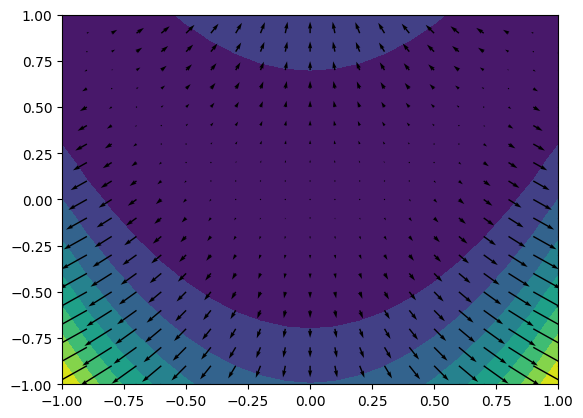

PyObject <matplotlib.quiver.Quiver object at 0x1176de8b0>

In [29]:
using PyPlot
xv = repeat(v, 1, n)
yv = repeat(v',n, 1)
contourf(xv, yv, z)
quiver(xv, yv, dz[:,:,1], dz[:,:,2])